In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.metrics import TopKCategoricalAccuracy
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Samples/Binary_Dataset.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Name      1956 non-null   object
 1   Sequence  1949 non-null   object
 2   Label     1956 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 46.0+ KB


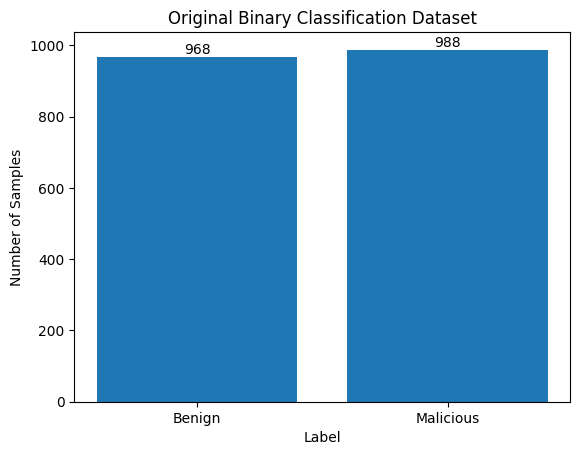

In [ ]:
label_counts = df['Label'].value_counts()

plt.bar(label_counts.index.astype(int), label_counts.values)

plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.title('Original Binary Classification Dataset')

plt.xticks([0, 1], ['Benign', 'Malicious'])

for i, count in enumerate(label_counts.values):
    plt.text(label_counts.index[i], count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
df.dropna(inplace=True)

X = df.drop('Label', axis=1)
y = df['Label']

rus = RandomUnderSampler(random_state=22)

X_resampled, y_resampled = rus.fit_resample(X, y)

df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Label'])], axis=1)

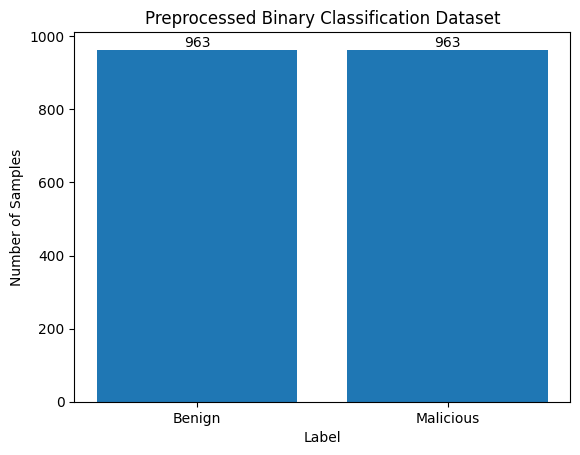

In [ ]:
label_counts = df['Label'].value_counts()

plt.bar(label_counts.index.astype(int), label_counts.values)

plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.title('Preprocessed Binary Classification Dataset')

plt.xticks([0, 1], ['Benign', 'Malicious'])

for i, count in enumerate(label_counts.values):
    plt.text(label_counts.index[i], count, str(count), ha='center', va='bottom')

plt.show()

# PREPROCESSING FUNCTIONS

In [ ]:
def strip_sequences(df, column_name):
  stripped_seq = df[column_name].apply(lambda x: [item.strip() for item in x.split(",")]).tolist()
  return stripped_seq

In [ ]:
from collections import defaultdict

def markov_mtrx(sequence):

  transitions = defaultdict(lambda: defaultdict(int))

  unique_calls = []
  for i in range(len(sequence) - 1):
    current_call = sequence[i]
    next_call = sequence[i+1]
    transitions[current_call][next_call] += 1
    if current_call not in unique_calls:
      unique_calls.append(current_call)

  df_probabilities = pd.DataFrame(index=unique_calls, columns=unique_calls)

  for row in unique_calls:
      total_transitions = sum(transitions[row].values())
      for col in unique_calls:
          if total_transitions > 0:
              df_probabilities.at[row, col] = transitions[row][col] / total_transitions
          else:
              df_probabilities.at[row, col] = 0

  df_probabilities = df_probabilities.fillna(0)
  return df_probabilities

In [ ]:
def create_markov_mrtx_list(data):
  datalist = []
  for sequence in data:
    datalist.append(markov_mtrx(sequence).values)

  return datalist

In [ ]:
def scale_values(matrix):
  return (matrix * 255).astype(np.uint8)

In [ ]:
from PIL import Image
import numpy as np

def create_image(scaled_matrix):

  # Create a PIL Image object from the array
  image = Image.fromarray(scaled_matrix, mode='L')  # 'L' mode is for grayscale

  return image

In [ ]:
def images_max_size(images):
  tuple_seq = []
  for image in images:
    tuple_seq.append(image.size)

  return max(tuple_seq, key=lambda x: x[1])

In [ ]:
import cv2

def add_padding(image, max_size):
  image_np = np.array(image)

  if image.size == max_size:
    return image
  else:
    pad_width = max_size[0] - image.size[0]
    pad_height = max_size[1] - image.size[1]

    top_pad = pad_height // 2
    bottom_pad = pad_height - top_pad
    left_pad = pad_width // 2
    right_pad = pad_width - left_pad

    padded_image = cv2.copyMakeBorder(image_np, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=0)
    return Image.fromarray(padded_image)

In [ ]:
def convert_images_to_arrays(image_objects):
    image_arrays = []
    for img_obj in image_objects:
        img_array = np.array(img_obj)
        image_arrays.append(img_array)
    return np.array(image_arrays)

In [ ]:
from tensorflow.keras.layers import BatchNormalization

def build_CNN(outputs, height, width, channels):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(outputs, activation='sigmoid'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# TEST

In [ ]:
data = strip_sequences(df=df, column_name="Sequence")
a = create_markov_mrtx_list(data)
scaled_a = []

for element in a:
  scaled_a.append(scale_values(element))

In [ ]:
images_a = []
for i in scaled_a:
  images_a.append(create_image(i))

In [ ]:
padded_imgs = []
for image in images_a:
  padded_imgs.append(add_padding(image, images_max_size(images_a)))

In [ ]:
df["Image"] = images_a

In [ ]:
df["Padded_Image"] = padded_imgs

In [ ]:
df["Padded_Image"]

0       <PIL.Image.Image image mode=L size=152x152 at ...
1       <PIL.Image.Image image mode=L size=152x152 at ...
2       <PIL.Image.Image image mode=L size=152x152 at ...
3       <PIL.Image.Image image mode=L size=152x152 at ...
4       <PIL.Image.Image image mode=L size=152x152 at ...
                              ...                        
1921    <PIL.Image.Image image mode=L size=152x152 at ...
1922    <PIL.Image.Image image mode=L size=152x152 at ...
1923    <PIL.Image.Image image mode=L size=152x152 at ...
1924    <PIL.Image.Image image mode=L size=152x152 at ...
1925    <PIL.Image.Image image mode=L size=152x152 at ...
Name: Padded_Image, Length: 1926, dtype: object

# ONLY TO SAVE THE IMAGES AND THE DATASET

In [ ]:
for index, row in df.iterrows():
    name = row['Name']
    img = row['Image']
    if row['Label'] == 0:
      img.save("/content/drive/MyDrive/Samples/Imgs/Binary_Imgs/Original/Safe/"+name.strip(".json")+".jpeg")
    else:
      img.save("/content/drive/MyDrive/Samples/Imgs/Binary_Imgs/Original/Malicious/"+name.strip(".json")+".jpeg")

In [ ]:
df.to_csv("/content/drive/MyDrive/Samples/Image_Binary_Dataset.csv", index=False)

# **RESULTS**

* #### **Precision:** 0.9775
* #### **Accuracy:** 0.9773
* #### **Recall:** 0.9773
* #### **F1-Score:** 0.9773
* #### **Precision Standard Deviation:** 0.020
* #### **Accuracy Standard Deviation:** 0.020
* #### **Recall Standard Deviation:** 0.020
* #### **F1-Score Standard Deviation:** 0.020

In [ ]:
avg_p = []
avg_a = []
avg_r = []
avg_f = []

precision_values = []
accuracy_values = []
recall_values = []
f1_values = []

X, y = convert_images_to_arrays(df["Padded_Image"]), np.array(df["Label"].tolist())

num_folds = 3

for i in range(3):
  print("Running iteration number:", i)
  kf = KFold(n_splits=num_folds, shuffle=True, random_state=22)

  precisions = []
  accuracies = []
  recalls = []
  f1s = []

  model = build_CNN(2, 152, 152, 1)

  fold_number = 1
  for train_index, test_index in kf.split(X):

    print(f"Fold: {fold_number}")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)

    model.fit(X_train, y_train, verbose=1, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

    predictions = model.predict(X_test)

    multiclass_predictions = np.argmax(predictions, axis=1)

    precision = precision_score(y_test, multiclass_predictions, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_test, multiclass_predictions)
    recall = recall_score(y_test, multiclass_predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_test, multiclass_predictions, average='weighted')

    print(precision, accuracy)

    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    fold_number = fold_number + 1

  avg_p.append(np.mean(precisions))
  avg_a.append(np.mean(accuracies))
  avg_r.append(np.mean(recalls))
  avg_f.append(np.mean(f1s))

  precision_values.extend(precisions)
  accuracy_values.extend(accuracies)
  recall_values.extend(recalls)
  f1_values.extend(f1s)

Running iteration number: 0
Fold: 1
Epoch 1/20
41/41 [==============================] - 89s 2s/step - loss: 3.1979 - accuracy: 0.7469 - val_loss: 1.1424 - val_accuracy: 0.8037
Epoch 2/20
41/41 [==============================] - 88s 2s/step - loss: 0.2436 - accuracy: 0.8933 - val_loss: 0.3919 - val_accuracy: 0.8629
Epoch 3/20
41/41 [==============================] - 97s 2s/step - loss: 0.1565 - accuracy: 0.9291 - val_loss: 0.2646 - val_accuracy: 0.9034
Epoch 4/20
41/41 [==============================] - 88s 2s/step - loss: 0.1213 - accuracy: 0.9517 - val_loss: 0.2376 - val_accuracy: 0.9330
Epoch 5/20
41/41 [==============================] - 96s 2s/step - loss: 0.0833 - accuracy: 0.9696 - val_loss: 0.1702 - val_accuracy: 0.9470
Epoch 6/20
41/41 [==============================] - 102s 2s/step - loss: 0.0675 - accuracy: 0.9829 - val_loss: 0.1950 - val_accuracy: 0.9346
Epoch 7/20
41/41 [==============================] - 90s 2s/step - loss: 0.0439 - accuracy: 0.9891 - val_loss: 0.1936 - val_

In [ ]:
precision_min = np.min(precision_values)
precision_max = np.max(precision_values)
precision_std = np.std(precision_values)

accuracy_min = np.min(accuracy_values)
accuracy_max = np.max(accuracy_values)
accuracy_std = np.std(accuracy_values)

recall_min = np.min(recall_values)
recall_max = np.max(recall_values)
recall_std = np.std(recall_values)

f1_min = np.min(f1_values)
f1_max = np.max(f1_values)
f1_std = np.std(f1_values)

In [ ]:
print(f'The precision values after 10 runs are -> Min: {np.min(precision_values)}, Mean: {np.mean(avg_p)}, Max: {np.max(precision_values)}, Std: {np.std(precision_values)}')
print(f'The accuracy values after 10 runs are -> Min: {np.min(accuracy_values)}, Mean: {np.mean(avg_a)}, Max: {np.max(accuracy_values)}, Std: {np.std(accuracy_values)}')
print(f'The recall values after 10 runs are -> Min: {np.min(recall_values)}, Mean: {np.mean(avg_r)}, Max: {np.max(recall_values)}, Std: {np.std(recall_values)}')
print(f'The F1 values after 10 runs are -> Min: {np.min(f1_values)}, Mean: {np.mean(avg_f)}, Max: {np.max(f1_values)}, Std: {np.std(f1_values)}')

The precision values after 10 runs are -> Min: 0.9475154813122962, Mean: 0.9775239377717567, Max: 1.0, Std: 0.019536567528567937
The accuracy values after 10 runs are -> Min: 0.9470404984423676, Mean: 0.9773277950848045, Max: 1.0, Std: 0.01969049865465961
The recall values after 10 runs are -> Min: 0.9470404984423676, Mean: 0.9773277950848045, Max: 1.0, Std: 0.01969049865465961
The F1 values after 10 runs are -> Min: 0.9470482085957506, Mean: 0.9773290944893888, Max: 1.0, Std: 0.019687032363519933
